<a href="https://colab.research.google.com/github/nahbos/AUT-Pattern-Recognition/blob/main/FastText_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Data from kaggle**

First, the data. first things first is installing kaggle to my environment i dont have to download the data to my drive/local. It's super efficient.

To get the API, go to your kaggle profile and download the JSON file!

In [94]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


download the dataset directly by copying the API command on the dataset page

In [95]:
! kaggle competitions download -c nlp-getting-started

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


#**Downloading pre-trained fastText, preparing datasets, and pre-processing**

In [ ]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [98]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Converting all the words to index in number, to the embedding index in pre-trained model and converted all the missing words to 0,

In [99]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


1999996it [04:08, 8040.11it/s]

found 1999996 word vectors


Read both the train data and test data

In [100]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [101]:
def nlprocess(dataset):
    
    preprocessed_comments = []
    for text in dataset:
        
        #Lowercase
        text = text.lower()

        # Removing Punctuation
        text = "".join([char for char in text if char not in string.punctuation])

        # Word Tokenization
        text = word_tokenize(text)

        # Stopword Filtering
        stop_words = stopwords.words('english')
        text = [word for word in text if word not in stop_words]

        # Stemming
        porter = PorterStemmer()
        text = [porter.stem(word) for word in text]

        text = ' '.join(text)

        preprocessed_comments.append(text)
        
    return preprocessed_comments

In [102]:
def spliter(datasets):
    x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets = [], [], [], []
    print('(train, test):')
    for i, dataset in enumerate(datasets):
        x_train, x_test, y_train, y_test = train_test_split(dataset.text, dataset.label, test_size=0.3, random_state=42)
        x_train_datasets.append(nlprocess(x_train))
        x_test_datasets.append(nlprocess(x_test))
        y_train_datasets.append(y_train)
        y_test_datasets.append(y_test)
        print(' |_ {}: ({}, {})'.format(datasets_name[i], len(x_train), len(x_test)))
    return x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets

In [103]:
from sklearn.model_selection import train_test_split
datasets_name = ['Amazon', 'IMDB  ', 'Yelp  ']

#load data
datasets = []
amazon = pd.read_csv('./amazon.txt', names=['text', 'label'], sep='\t')
imdb   = pd.read_csv('./imdb.txt', names=['text', 'label'], sep='\t')
yelp   = pd.read_csv('./yelp.txt', names=['text', 'label'], sep='\t')

datasets.append(amazon)
datasets.append(imdb)
datasets.append(yelp)

x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets = spliter(datasets)

(train, test):
 |_ Amazon: (700, 300)
 |_ IMDB  : (700, 300)
 |_ Yelp  : (700, 300)


In [104]:
train_df = pd.DataFrame(x_train_datasets[0], columns=['text'])
test_df = pd.DataFrame(x_test_datasets[0], columns=['text'])
y_train = y_train_datasets[0]
y_test = y_test_datasets[0]

In [105]:
y_test_datasets[0]

521    1
737    1
740    1
660    0
411    1
      ..
468    0
935    0
428    1
7      1
155    1
Name: label, Length: 300, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


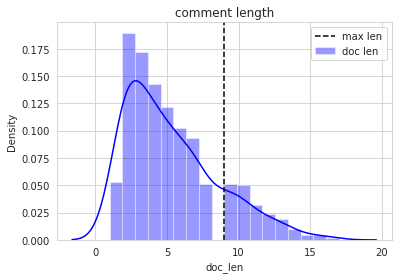

In [106]:
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(' ')))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

tokenizing the data with tokenizer from tensorflow

In [107]:
from sklearn.utils import shuffle 

label_names = ["label"]
raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 300/300 [00:00<00:00, 8929.62it/s]

tokenizing input data...
dictionary size:  1475


In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
def feature_extractor(dataset):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(dataset)
    return vectorizer

In [109]:
vectorizers = []
for i, dataset in enumerate(x_train_datasets):
    vectorizer = feature_extractor(dataset)  
    vectorizers.append(vectorizer)

In [110]:
from sklearn.linear_model import LogisticRegression

print("Accuracy:")
clfs = []
vectorized_trains = []
vectorized_tests = []

for i, (vec, x_tr, x_ts, y_tr, y_ts) in enumerate(zip(vectorizers, x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets)):
    X_train = vec.transform(x_tr)
    X_test = vec.transform(x_ts)

    vectorized_trains.append(X_train)
    vectorized_tests.append(X_test)
    
    clf = LogisticRegression()
    clf.fit(X_train, y_tr)
    clfs.append(clf)
    score = clf.score(X_test, y_ts)
    
    print(' |_  {}: {:.2f}'.format(datasets_name[i], score))

Accuracy:
 |_  Amazon: 0.81
 |_  IMDB  : 0.81
 |_  Yelp  : 0.77


#**Shape and Train with LSTM**

defining variables that used on training

In [111]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

building the embedding matrix for the weights in Embedding Layer on training. more about embedding matrix: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

all words that aren't in the pre-trained model from fasttext would be changed to 0. the words are basically the ones with typos or names, the words mostly dont matter so much to the pattern. so it's nicer to just weights it 0.

In [112]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 229


In [113]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['samsungcrap' 'situations1' 'windresist' 'heavyit' 'seper' 'pleasantli'
 'onethi' 'tmobil' 'schr450' 'clearli']


let's start training! here are the layers. i have been doing some test and modification on using the layer, unit cells, etc. and so far it works the best for me. tell me i

In [114]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 300)            442800    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               85248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 530,161
Trainable params: 87,361
Non-trainable params: 442,800
_____________________________________________

In [115]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [116]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
2/2 [==============================] - 6s 1s/step - loss: 0.6941 - accuracy: 0.5358 - val_loss: 0.6938 - val_accuracy: 0.5024
Epoch 2/40
2/2 [==============================] - 0s 80ms/step - loss: 0.6820 - accuracy: 0.6094 - val_loss: 0.6838 - val_accuracy: 0.5924
Epoch 3/40
2/2 [==============================] - 0s 93ms/step - loss: 0.6708 - accuracy: 0.6483 - val_loss: 0.6759 - val_accuracy: 0.6635
Epoch 4/40
2/2 [==============================] - 0s 88ms/step - loss: 0.6584 - accuracy: 0.7178 - val_loss: 0.6683 - val_accuracy: 0.7109
Epoch 5/40
2/2 [==============================] - 0s 90ms/step - loss: 0.6522 - accuracy: 0.7035 - val_loss: 0.6605 - val_accuracy: 0.7156
Epoch 6/40
2/2 [==============================] - 0s 84ms/step - loss: 0.6421 - accuracy: 0.7526 - val_loss: 0.6525 - val_accuracy: 0.7109
Epoch 7/40
2/2 [==============================] - 0s 85ms/step - loss: 0.6243 - accuracy: 0.7607 - val_loss: 0.6439 - val_accuracy: 0.7109
Epoch 8/40
2/2 [=============

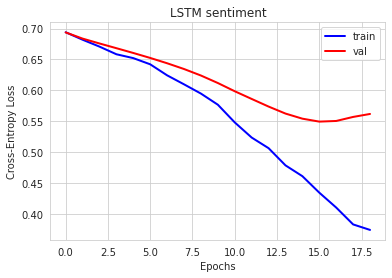

In [117]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

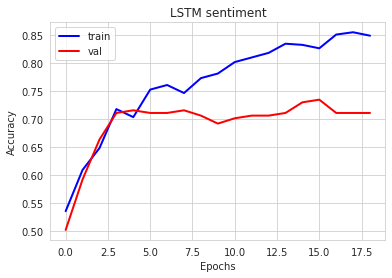

In [118]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [119]:
# predictions = model.predict_classes(word_seq_test)
predictions = (model.predict(word_seq_test) > 0.5).astype("int32")
test_df['pred'] = predictions

In [120]:
import sklearn

print("Accuracy With fastText :")
print(sklearn.metrics.accuracy_score(y_test, test_df.pred))

Accuracy With fastText :
0.77


In [121]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

it's **80%**! not so good but also not that bad, huh?

# **LET'S COMPARE WITH GLOVE!**

In [ ]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [122]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('/content/glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


2196018it [04:43, 7745.30it/s]

found 2196016 word vectors


In [123]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 300/300 [00:00<00:00, 8494.28it/s]


tokenizing input data...
dictionary size:  1475


In [124]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_glove = tf.keras.Sequential()

model_glove.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model_glove.add(Bidirectional(LSTM(32)))
model_glove.add(Dense(32,activation='relu'))
model_glove.add(Dropout(0.4))
model_glove.add(Dense(1,activation='sigmoid'))
model_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 300)            442800    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               85248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 530,161
Trainable params: 87,361
Non-trainable params: 442,800
_____________________________________________

In [125]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [126]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = model_glove.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
2/2 [==============================] - 7s 1s/step - loss: 0.6964 - accuracy: 0.4908 - val_loss: 0.6904 - val_accuracy: 0.5213
Epoch 2/40
2/2 [==============================] - 0s 86ms/step - loss: 0.6879 - accuracy: 0.5726 - val_loss: 0.6868 - val_accuracy: 0.5877
Epoch 3/40
2/2 [==============================] - 0s 91ms/step - loss: 0.6804 - accuracy: 0.6115 - val_loss: 0.6817 - val_accuracy: 0.6540
Epoch 4/40
2/2 [==============================] - 0s 92ms/step - loss: 0.6696 - accuracy: 0.6748 - val_loss: 0.6751 - val_accuracy: 0.6872
Epoch 5/40
2/2 [==============================] - 0s 97ms/step - loss: 0.6612 - accuracy: 0.7055 - val_loss: 0.6675 - val_accuracy: 0.7204
Epoch 6/40
2/2 [==============================] - 0s 105ms/step - loss: 0.6527 - accuracy: 0.7117 - val_loss: 0.6591 - val_accuracy: 0.7251
Epoch 7/40
2/2 [==============================] - 0s 89ms/step - loss: 0.6379 - accuracy: 0.7628 - val_loss: 0.6492 - val_accuracy: 0.7204
Epoch 8/40
2/2 [============

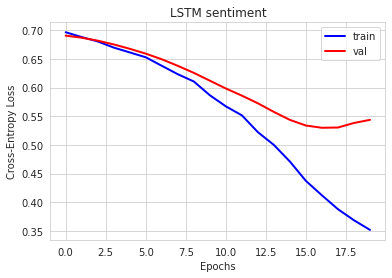

In [127]:
#generate plots
plt.figure()
plt.plot(history_glove.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

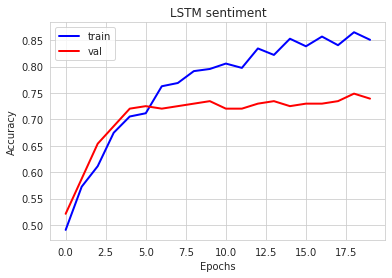

In [128]:
plt.figure()
plt.plot(history_glove.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [129]:
predictions = model_glove.predict(word_seq_test > 0.5).astype(int)
test_df['pred']= predictions

In [132]:
import sklearn
print("Accuracy With GloVe :")
print(sklearn.metrics.accuracy_score(y_test, test_df.pred))

Accuracy With GloVe :
0.4866666666666667


In [135]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

# **COMPARE WITHOUT WORD EMBEDDING**

In [137]:
from keras.layers import BatchNormalization
import tensorflow as tf

without_mod = tf.keras.Sequential()

without_mod.add(Embedding(nb_words,embed_dim,input_length=max_seq_len,trainable=False))
without_mod.add(Bidirectional(LSTM(32)))
without_mod.add(Dense(32,activation='relu'))
without_mod.add(Dropout(0.4))
without_mod.add(Dense(1,activation='sigmoid'))
without_mod.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 9, 300)            442800    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               85248     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 530,161
Trainable params: 87,361
Non-trainable params: 442,800
___________________________________________

In [139]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

without_mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [140]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = without_mod.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
2/2 [==============================] - 7s 2s/step - loss: 0.6938 - accuracy: 0.4990 - val_loss: 0.6924 - val_accuracy: 0.4882
Epoch 2/40
2/2 [==============================] - 0s 84ms/step - loss: 0.6931 - accuracy: 0.5153 - val_loss: 0.6921 - val_accuracy: 0.4929
Epoch 3/40
2/2 [==============================] - 0s 87ms/step - loss: 0.6919 - accuracy: 0.5153 - val_loss: 0.6917 - val_accuracy: 0.5118
Epoch 4/40
2/2 [==============================] - 0s 90ms/step - loss: 0.6922 - accuracy: 0.5092 - val_loss: 0.6916 - val_accuracy: 0.5545
Epoch 5/40
2/2 [==============================] - 0s 90ms/step - loss: 0.6903 - accuracy: 0.5808 - val_loss: 0.6914 - val_accuracy: 0.5829
Epoch 6/40
2/2 [==============================] - 0s 95ms/step - loss: 0.6902 - accuracy: 0.6074 - val_loss: 0.6909 - val_accuracy: 0.5877
Epoch 7/40
2/2 [==============================] - 0s 90ms/step - loss: 0.6889 - accuracy: 0.5992 - val_loss: 0.6903 - val_accuracy: 0.6066
Epoch 8/40
2/2 [=============

In [142]:
predictions = without_mod.predict(word_seq_test > 0.5).astype(int)
test_df['pred']= predictions

In [143]:
import sklearn
print("Accuracy With GloVe :")
print(sklearn.metrics.accuracy_score(y_test, test_df.pred))

Accuracy With GloVe :
0.4866666666666667
